Data loading

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Define column names
column_names = ['user_id', 'item_id', 'rating']

path = '../data'
interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])
interaction['implicit_rating'] = np.where(interaction['rating'] >= 3, 1, 0)
interaction = interaction.drop(labels='rating', axis=1)
interaction

C:\Users\admin\AppData\Local\Temp\ipykernel_23100\1018464135.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  interaction = pd.read_csv(path + '/ratings.dat', sep='::', names=column_names, usecols=['user_id', 'item_id', 'rating'])


,user_id,item_id,implicit_rating
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1
...,...,...,...
1000204,6040,1091,0
1000205,6040,1094,1
1000206,6040,562,1
1000207,6040,1096,1


Data supplement

In [32]:
user_engagement = interaction.groupby(by='user_id')['implicit_rating'].sum().reset_index()
user_engagement.columns = ['user_id', 'user_engagement']

interaction = pd.merge(interaction, user_engagement, on='user_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement
0,1,1193,1,53
1,1,661,1,53
2,1,914,1,53
3,1,3408,1,53
4,1,2355,1,53
...,...,...,...,...
1000204,6040,1091,0,276
1000205,6040,1094,1,276
1000206,6040,562,1,276
1000207,6040,1096,1,276


In [33]:
movie_popularity = interaction.groupby(by='item_id')['implicit_rating'].sum().reset_index()
movie_popularity.columns = ['item_id', 'movie_popularity']

interaction = pd.merge(interaction, movie_popularity, on='item_id', how='left')
interaction

,user_id,item_id,implicit_rating,user_engagement,movie_popularity
0,1,1193,1,53,1680
1,1,661,1,53,443
2,1,914,1,53,611
3,1,3408,1,53,1223
4,1,2355,1,53,1599
...,...,...,...,...,...
1000204,6040,1091,0,276,237
1000205,6040,1094,1,276,1100
1000206,6040,562,1,276,425
1000207,6040,1096,1,276,316


Data split

In [34]:
# Encode user_id and item_id
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

interaction['user_id'] = user_encoder.fit_transform(interaction['user_id'])
interaction['item_id'] = movie_encoder.fit_transform(interaction['item_id'])
    
# Prepare features (X) and labels (y)
#X = interaction[['user_id', 'item_id', 'user_engagement', 'movie_popularity']]
X = interaction[['user_id', 'item_id', 'user_engagement', 'movie_popularity']]
y = interaction['implicit_rating']
    
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,user_id,item_id,user_engagement,movie_popularity
416292,2506,2821,751,407
683230,4086,2633,38,269
2434,18,443,214,1941
688533,4117,2599,194,1290
472584,2906,759,654,304
...,...,...,...,...
259178,1585,1005,410,696
365838,2128,2495,264,1061
131932,853,2886,378,218
671155,4032,3246,596,486


Investigate model under n_estimator settings

In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import time

n_estimators = [10, 20, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
train_times = []
rmses = []

train_time = 0

### Model training
for n_estimator in n_estimators:
    start_train_time = time.time()
    
    xgb_regressor = XGBRegressor(objective='binary:logistic', n_estimators = n_estimator, colsample_bytree = 0.3, max_depth = 10, learning_rate = 0.1)

    xgb_regressor.fit(X_train, y_train)

    y_pred = xgb_regressor.predict(X_test)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{n_estimator}: {rmse}")
    print(f"Execution time@{n_estimator}: {train_time}")
    print("---------------------------------------------")

    train_times.append(train_time)
    rmses.append(rmse)

RMSE@10: 0.36227389009202965
Execution time@10: 0.5581660270690918
---------------------------------------------
RMSE@20: 0.3571422185631534
Execution time@20: 1.0025107860565186
---------------------------------------------
RMSE@50: 0.350950352455478
Execution time@50: 2.5784459114074707
---------------------------------------------
RMSE@100: 0.34841506666323074
Execution time@100: 4.153428792953491
---------------------------------------------
RMSE@150: 0.34756276337407727
Execution time@150: 7.223578691482544
---------------------------------------------
RMSE@200: 0.3472653545490868
Execution time@200: 10.552038431167603
---------------------------------------------
RMSE@250: 0.3471391351052399
Execution time@250: 12.39675235748291
---------------------------------------------
RMSE@300: 0.34707244301979023
Execution time@300: 17.872457027435303
---------------------------------------------
RMSE@350: 0.34702888750301386
Execution time@350: 16.631722450256348
-------------------------

Line graph

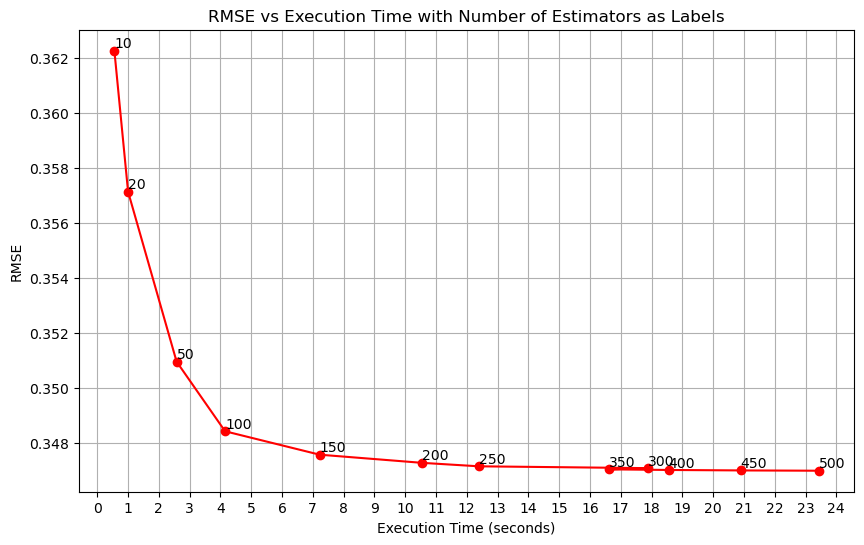

In [36]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times, rmses, marker='o', color='r', linestyle='-')

# Adding labels for each point to show n_estimators
for i, n_estimator in enumerate(n_estimators):
    plt.text(train_times[i], rmses[i], str(n_estimator), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times)
plt.xticks(np.arange(0, max_time + 1, 1))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Number of Estimators as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

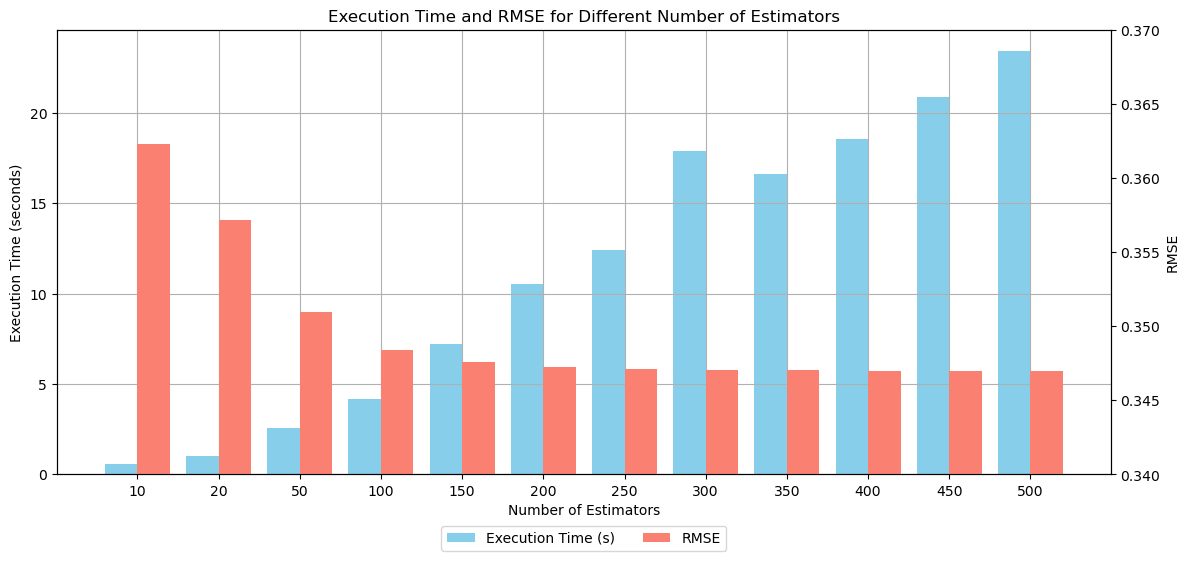

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(n_estimators)) - 0.2, train_times, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Number of Estimators")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(n_estimators)) + 0.2, rmses, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(n_estimators)), n_estimators)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.37)

# Title and grid
plt.title("Execution Time and RMSE for Different Number of Estimators")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Investigate model under max_depth settings

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import time

max_depths = [1, 2, 4, 6, 8, 10, 12, 15, 20]
train_times = []
rmses = []

train_time = 0

### Model training
for max_depth in max_depths:
    start_train_time = time.time()
    
    xgb_regressor = XGBRegressor(objective='binary:logistic', n_estimators = 50, colsample_bytree = 0.3, max_depth = max_depth, learning_rate = 0.1)

    xgb_regressor.fit(X_train, y_train)

    y_pred = xgb_regressor.predict(X_test)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{max_depth}: {rmse}")
    print(f"Execution time@{max_depth}: {train_time}")
    print("---------------------------------------------")

    train_times.append(train_time)
    rmses.append(rmse)

RMSE@1: 0.3611169522606099
Execution time@1: 0.7953066825866699
---------------------------------------------
RMSE@2: 0.3580032515819062
Execution time@2: 1.0220527648925781
---------------------------------------------
RMSE@4: 0.35572146142254274
Execution time@4: 1.446115255355835
---------------------------------------------
RMSE@6: 0.35351984844777834
Execution time@6: 1.8496184349060059
---------------------------------------------
RMSE@8: 0.3519515685006828
Execution time@8: 2.3468382358551025
---------------------------------------------
RMSE@10: 0.350950352455478
Execution time@10: 2.7467329502105713
---------------------------------------------
RMSE@12: 0.3505319443403464
Execution time@12: 2.9845809936523438
---------------------------------------------
RMSE@15: 0.3503076241129492
Execution time@15: 3.3345608711242676
---------------------------------------------
RMSE@20: 0.35022485742365594
Execution time@20: 3.2599833011627197
---------------------------------------------


Line graph

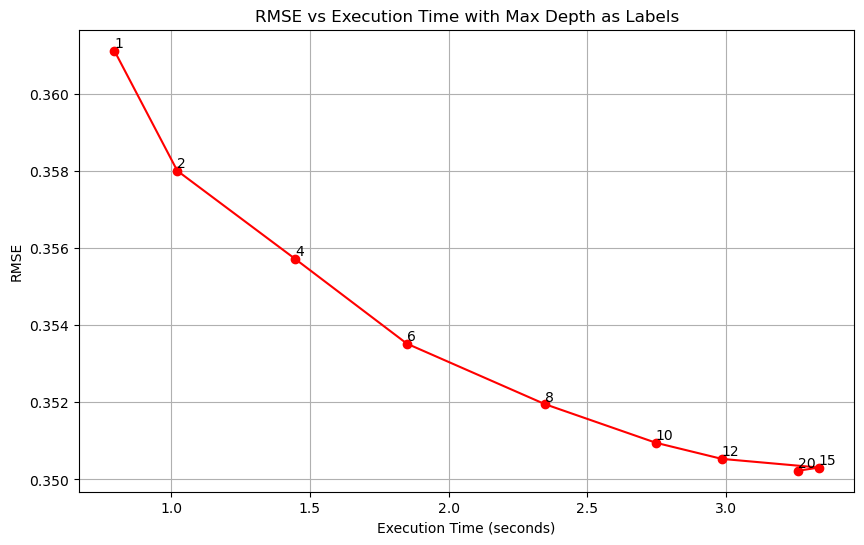

In [39]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Plotting RMSE vs Execution Time
plt.figure(figsize=(10, 6))
plt.plot(train_times, rmses, marker='o', color='r', linestyle='-')

# Adding labels for each point to show max_depth
for i, max_depth in enumerate(max_depths):
    plt.text(train_times[i], rmses[i], str(max_depth), ha='left', va='bottom', color='black')

# Set x-axis ticks at every 1-second interval
max_time = max(train_times)
#plt.xticks(np.arange(0, max_time + 1, 1))  # Adjusting to show every second

# Labels, title, and grid
plt.title("RMSE vs Execution Time with Max Depth as Labels")
plt.xlabel("Execution Time (seconds)")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

Bar plot

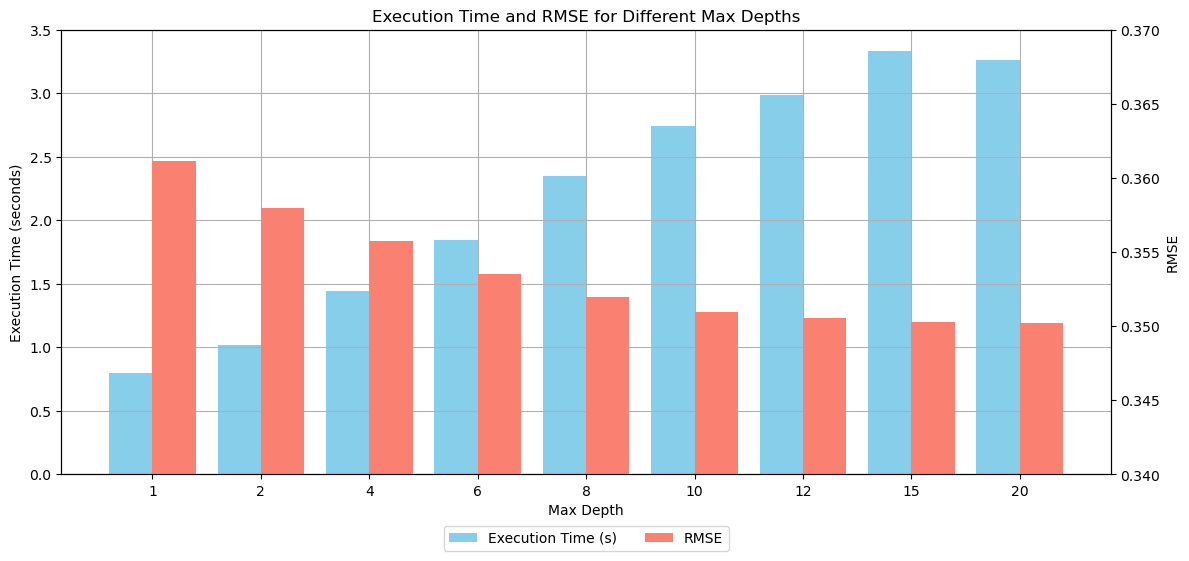

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(max_depths)) - 0.2, train_times, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Max Depth")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(max_depths)) + 0.2, rmses, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(max_depths)), max_depths)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.34, 0.37)

# Title and grid
plt.title("Execution Time and RMSE for Different Max Depths")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Investigate model under regularization settings

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import time

reg_alphas = [0, 0.5, 1.0, 2.0, 5.0]
reg_lambdas = [0, 0.5, 1.0, 2.0, 5.0]
train_times = {}
rmses = {}

train_time = 0

### Model training
for alpha in reg_alphas:
    for lambd in reg_lambdas:
        start_train_time = time.time()
    
        xgb_regressor = XGBRegressor(objective='binary:logistic', n_estimators = 50, colsample_bytree = 0.3, max_depth = 6, reg_alpha = alpha, reg_lambda = lambd, learning_rate = 0.1)

        xgb_regressor.fit(X_train, y_train)

        y_pred = xgb_regressor.predict(X_test)

        end_train_time = time.time()
        #train_time = train_time + (end_train_time - start_train_time)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"RMSE@{alpha}/{lambd}: {rmse}")
        #print(f"Execution time@{alpha}/{lambd}: {train_time}")
        print("---------------------------------------------")

        #train_times[(alpha, lambd)] = train_time
        rmses[(alpha, lambd)] = rmse

RMSE@0/0: 0.3535524908419136
---------------------------------------------
RMSE@0/0.5: 0.35352100640131634
---------------------------------------------
RMSE@0/1.0: 0.35351984844777834
---------------------------------------------
RMSE@0/2.0: 0.353525193630623
---------------------------------------------
RMSE@0/5.0: 0.35355413758161
---------------------------------------------
RMSE@0.5/0: 0.3535243515945854
---------------------------------------------
RMSE@0.5/0.5: 0.353527085676358
---------------------------------------------
RMSE@0.5/1.0: 0.3535250092851564
---------------------------------------------
RMSE@0.5/2.0: 0.35353782250378707
---------------------------------------------
RMSE@0.5/5.0: 0.35354550292790154
---------------------------------------------
RMSE@1.0/0: 0.35353277587556614
---------------------------------------------
RMSE@1.0/0.5: 0.3535335619318786
---------------------------------------------
RMSE@1.0/1.0: 0.35353124886443016
---------------------------------

Heatmap

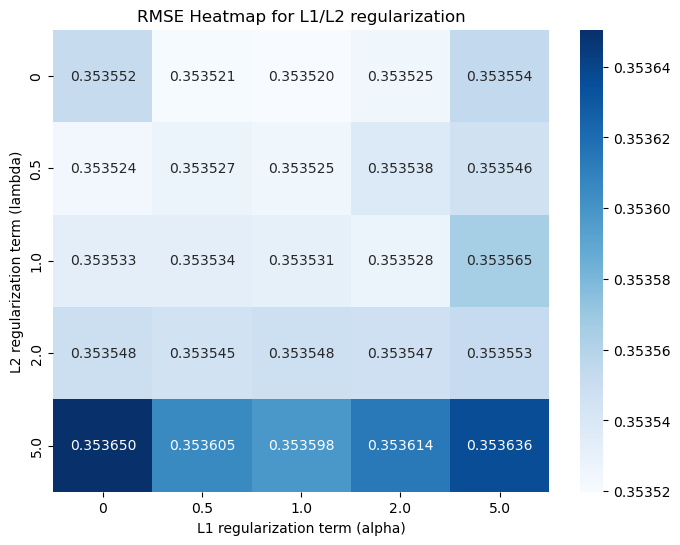

In [42]:
rmse_matrix = np.array([[rmses[(a, l)] for l in reg_lambdas] for a in reg_alphas])
#time_matrix = np.array([[train_times[(a, l)] for l in reg_lambdas] for a in reg_alphas])
import seaborn as sns

# Plot the heatmap using seaborn
plt.figure(figsize=(8, 6))
ax = sns.heatmap(rmse_matrix, annot=True, fmt=".6f", cmap="Blues", xticklabels=reg_alphas, yticklabels=reg_lambdas)

# Add labels and title
ax.set_xlabel("L1 regularization term (alpha)")
ax.set_ylabel("L2 regularization term (lambda)")
ax.set_title("RMSE Heatmap for L1/L2 regularization")

# Show plot
plt.show()

Investigate model under objective settings

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import time

metrics = ['count:poisson', 'reg:squarederror', 'binary:logistic']
train_times = []
rmses = []

train_time = 0

### Model training
for metric in metrics:
    start_train_time = time.time()
    
    xgb_regressor = XGBRegressor(objective=metric, n_estimators = 50, colsample_bytree = 0.3, max_depth = 10, learning_rate = 0.1)

    xgb_regressor.fit(X_train, y_train)

    y_pred = xgb_regressor.predict(X_test)

    end_train_time = time.time()
    train_time = (end_train_time - start_train_time)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE@{metric}: {rmse}")
    print(f"Execution time@{metric}: {train_time}")
    print("---------------------------------------------")

    train_times.append(train_time)
    rmses.append(rmse)

RMSE@count:poisson: 0.3565719251263223
Execution time@count:poisson: 3.492823600769043
---------------------------------------------
RMSE@reg:squarederror: 0.3518958011796861
Execution time@reg:squarederror: 3.5498385429382324
---------------------------------------------
RMSE@binary:logistic: 0.350950352455478
Execution time@binary:logistic: 2.92053484916687
---------------------------------------------


Bar plot

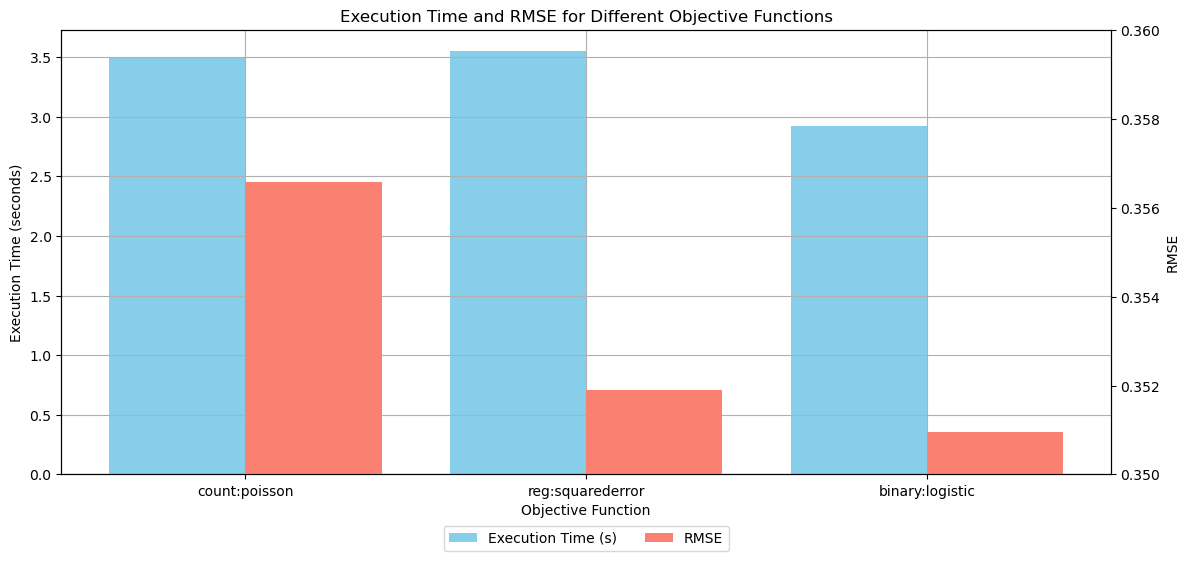

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Execution Time
bars1 = ax1.bar(np.arange(len(metrics)) - 0.2, train_times, width=0.4, label="Execution Time (s)", color='skyblue')
ax1.set_xlabel("Objective Function")
ax1.set_ylabel("Execution Time (seconds)", color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Bar plot for RMSE on a secondary y-axis with adjusted range
ax2 = ax1.twinx()
bars2 = ax2.bar(np.arange(len(metrics)) + 0.2, rmses, width=0.4, label="RMSE", color='salmon')
ax2.set_ylabel("RMSE", color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Set x-axis labels to max_depth values
plt.xticks(np.arange(len(metrics)), metrics)

# Adjust RMSE y-axis range for better visibility
ax2.set_ylim(0.35, 0.36)

# Title and grid
plt.title("Execution Time and RMSE for Different Objective Functions")
ax1.grid(True)

# Adding a combined legend at the bottom
plt.legend([bars1, bars2], ["Execution Time (s)", "RMSE"], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


Calculate extra evaluation metrics (Recall@5, Precision@5)

In [45]:
from sklearn.metrics import precision_score, recall_score

X_test['pred_score'] = y_pred
X_test['actual_interaction'] = y_test.values

# **Top 5 Precision and Recall Calculation**
# Group by user and get top 5 predictions for each user
top_5_recs = X_test.sort_values(['user_id', 'pred_score'], ascending=[True, False]) \
                   .groupby('user_id').head(5)

# Calculate Precision@5 and Recall@5
precision_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: precision_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 95)).astype(int))
).mean()

recall_at_5 = top_5_recs.groupby('user_id').apply(
    lambda x: recall_score(x['actual_interaction'], (x['pred_score'] >= np.percentile(x['pred_score'], 95)).astype(int))
).mean()

print(f"Precision@5: {precision_at_5}")
print(f"Recall@5: {recall_at_5}")

d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divis

Precision@5: 0.9529645578005962
Recall@5: 0.2185988737992713
